In [1]:
from __future__ import annotations

import re
import json
from string import punctuation

import spacy
from spacy import displacy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'svg'


In [2]:
de = spacy.load('de_dep_news_trf')
el = spacy.load('el_core_news_lg')


In [15]:
MODELS = {
    'de': de,
    'el': el
}

COLORS = {
    'de': '#a52040',
    'el': '#404080',
    'stern_yellow': '#c3c31d',
    'stern_blue': '#0b3f7e',
    'stern_purple': '#7c7cf8',
    'stern_darkbrown': '#370306',
    'darkgreen': '#006400',
    'orange': '#f4a460',
    'green': '#90ee90',
    'blue': '#add8e6',
    'purple': '#800080',
    'err': '#b4b446',
}

POS_COLORS = [
    "#FFD700",  # Gold
    "#90EE90",  # Light Green
    "#FFA07A",  # Light Salmon
    "#AFEEEE",  # Pale Turquoise
    "#F08080",  # Light Coral
    "#ADD8E6",  # Light Blue
    "#FFB6C1",  # Light Pink
    "#FFE4B5",  # Moccasin
    "#B0E0E6",  # Powder Blue
    "#D3D3D3",  # Light Grey
    "#E6E6FA",  # Lavender
    "#FFDEAD",  # Navajo White
    "#F5DEB3",  # Wheat
    "#FFFACD",  # Lemon Chiffon
    "#BDB76B",  # Dark Khaki
    "#8787df",  # Light Slate Blue
    "#E0FFFF",  # Light Cyan
]


In [4]:
texts = pd.read_csv('examples.csv', sep=',', encoding='utf-8')

with pd.option_context('display.max_colwidth', None):
    display(texts)


,id,lang,version,text
0,1,el,ελλΑΚ-1940,Κατὰ τὴν ἑρμηνείαν τῆς δηλώσεως βουλήσεως ἀναζητεῖται ἤ ἀληθὴς βούλησις ἄνευ προσηλώσεως εἱς τὰς λέξεις. (ΑΚ 173)
1,1,el,ελλΑΚ-2023,Κατά την ερμηνεία της δήλωσης βουλήσεως αναζητείται η αληθινή βούληση χωρίς προσήλωση στις λέξεις. (AK 173)
2,1,de,γερΑΚ-2023,Bei der Auslegung einer Willenserklärung ist der wirkliche Wille zu erforschen und nicht an dem buchstäblichen Sinne des Ausdrucks zu haften. (BGB § 133)
3,1,de,ελλΑΚ-1951,"Bei der Auslegung einer Willenserklärung wird der wirkliche Wille erforscht, ohne an den Worten zu haften."


In [5]:
def remove_crossrefs(text):
    """Remove cross references from text.
    A cross reference is a string of the form (ΑΚ 123) or (BGB § 123)."""
    pattern = r'\((ΑΚ|AK|BGB)\s*§?\s*\d+\)'
    return re.sub(pattern, '', text)

def remove_punctuation(text: str) -> str:
    return re.sub(r'[{}]'.format(punctuation), '', text)

def get_morphology_dict(token: spacy.tokens.token.Token) -> str:
    """Return a dictionary of each token and its morphology from a text in a nested dictionary."""
    return {token.text: token.morph.to_dict()}

get_morphology_dict(de('Das ist ein Test')[0])


{'Das': {'Case': 'Nom', 'Gender': 'Neut', 'Number': 'Sing', 'PronType': 'Dem'}}

In [6]:
texts['pos'] = texts['length'] = texts['morphology'] = np.nan

for i, text in enumerate(texts['text'].to_list()):
    text = remove_crossrefs(text)
    doc = MODELS[texts['lang'][i]](text)
    texts.loc[i, 'length'] = len([token.text for token in doc
                                  if not token.is_punct and not token.is_digit])
    texts.loc[i, 'pos'] = " ".join([token.pos_ for token in doc])
    texts.loc[i, 'morphology'] = json.dumps([get_morphology_dict(token)
                                             for token in doc],
                                            ensure_ascii=False)
    displacy.render(doc, style='dep', jupyter=True)

texts['length'] = texts['length'].astype(int)


In [18]:
from spacy.language import Language
from spacy.tokens import Doc
from spacy.language import Language
from IPython.core.display import HTML
from IPython.display import display

class CustomTagger:
    def __init__(self, nlp):
        self.nlp = nlp

    def __call__(self, doc: Doc) -> Doc:
        for token in doc:
            token.tag_ = token.pos_
        return doc

if not Language.has_factory("custom_tagger"):
    @Language.factory("custom_tagger")
    def create_custom_tagger(nlp, name):
        return CustomTagger(nlp)

def visualize_pos(text: str, model: str, *, colors: list) -> str:
    try:
        nlp = MODELS[model]
    except KeyError:
        print(f"Model {model!r} not found. Choose from: {list(MODELS.keys())}")
        return None

    if "custom_tagger" not in nlp.pipe_names:
        nlp.add_pipe("custom_tagger", before="morphologizer")

    doc = nlp(text)

    # get the labels, iterate over them and extract the POS tags
    pos_tags = list(nlp.get_pipe('custom_tagger').labels)
    pos_tags = [tag.split('POS=')[1].split('|')[0] for tag in pos_tags]
    pos_tags = sorted(list(set(pos_tags)))

    colormap = dict(zip(pos_tags, colors))

    ents = []
    for token in doc:
        if token.pos_ in pos_tags:
            ents.append({'start': token.idx,
                         'end': token.idx + len(token),
                         'label': token.pos_})

    doc = {'text': text, 'ents': ents}

    options = {'ents': pos_tags, 'colors': colormap}

    html = displacy.render(doc,
                           style='ent',
                           options=options,
                           manual=True,
                           jupyter=True,
                           )
    return html


In [19]:
for i, text in enumerate(texts['text'].to_list()):
    html_output = visualize_pos(text, texts['lang'][i], colors=POS_COLORS)
    display(HTML(html_output))


17


<IPython.core.display.HTML object>

17


<IPython.core.display.HTML object>

16


<IPython.core.display.HTML object>

16


<IPython.core.display.HTML object>

In [20]:
with pd.option_context('display.max_colwidth', None):
    display(texts)


,id,lang,version,text,pos,length,morphology
0,1,el,ελλΑΚ-1940,Κατὰ τὴν ἑρμηνείαν τῆς δηλώσεως βουλήσεως ἀναζητεῖται ἤ ἀληθὴς βούλησις ἄνευ προσηλώσεως εἱς τὰς λέξεις. (ΑΚ 173),ADP DET NOUN DET NOUN NOUN VERB PROPN ADV NOUN ADJ ADJ ADP DET NOUN PUNCT,15,"[{""Κατὰ"": {}}, {""τὴν"": {""Case"": ""Acc"", ""Definite"": ""Def"", ""Gender"": ""Fem"", ""Number"": ""Sing"", ""PronType"": ""Art""}}, {""ἑρμηνείαν"": {""Case"": ""Acc"", ""Gender"": ""Fem"", ""Number"": ""Sing""}}, {""τῆς"": {""Case"": ""Gen"", ""Definite"": ""Def"", ""Gender"": ""Fem"", ""Number"": ""Sing"", ""PronType"": ""Art""}}, {""δηλώσεως"": {""Case"": ""Gen"", ""Gender"": ""Fem"", ""Number"": ""Sing""}}, {""βουλήσεως"": {""Case"": ""Gen"", ""Gender"": ""Fem"", ""Number"": ""Sing""}}, {""ἀναζητεῖται"": {""Aspect"": ""Imp"", ""Mood"": ""Ind"", ""Number"": ""Sing"", ""Person"": ""3"", ""Tense"": ""Pres"", ""VerbForm"": ""Fin"", ""Voice"": ""Pass""}}, {""ἤ"": {""Case"": ""Gen"", ""Gender"": ""Fem"", ""Number"": ""Plur""}}, {""ἀληθὴς"": {}}, {""βούλησις"": {""Case"": ""Acc"", ""Gender"": ""Fem"", ""Number"": ""Sing""}}, {""ἄνευ"": {""Case"": ""Acc"", ""Gender"": ""Fem"", ""Number"": ""Plur""}}, {""προσηλώσεως"": {""Case"": ""Acc"", ""Gender"": ""Fem"", ""Number"": ""Sing""}}, {""εἱς"": {}}, {""τὰς"": {""Case"": ""Acc"", ""Definite"": ""Def"", ""Gender"": ""Fem"", ""Number"": ""Plur"", ""PronType"": ""Art""}}, {""λέξεις"": {""Case"": ""Acc"", ""Gender"": ""Fem"", ""Number"": ""Plur""}}, {""."": {}}]"
1,1,el,ελλΑΚ-2023,Κατά την ερμηνεία της δήλωσης βουλήσεως αναζητείται η αληθινή βούληση χωρίς προσήλωση στις λέξεις. (AK 173),ADP DET NOUN DET NOUN NOUN VERB DET ADJ NOUN ADP NOUN ADP NOUN PUNCT,14,"[{""Κατά"": {}}, {""την"": {""Case"": ""Acc"", ""Definite"": ""Def"", ""Gender"": ""Fem"", ""Number"": ""Sing"", ""PronType"": ""Art""}}, {""ερμηνεία"": {""Case"": ""Acc"", ""Gender"": ""Fem"", ""Number"": ""Sing""}}, {""της"": {""Case"": ""Gen"", ""Definite"": ""Def"", ""Gender"": ""Fem"", ""Number"": ""Sing"", ""PronType"": ""Art""}}, {""δήλωσης"": {""Case"": ""Gen"", ""Gender"": ""Fem"", ""Number"": ""Sing""}}, {""βουλήσεως"": {""Case"": ""Gen"", ""Gender"": ""Fem"", ""Number"": ""Sing""}}, {""αναζητείται"": {""Aspect"": ""Imp"", ""Mood"": ""Ind"", ""Number"": ""Sing"", ""Person"": ""3"", ""Tense"": ""Pres"", ""VerbForm"": ""Fin"", ""Voice"": ""Pass""}}, {""η"": {""Case"": ""Nom"", ""Definite"": ""Def"", ""Gender"": ""Fem"", ""Number"": ""Sing"", ""PronType"": ""Art""}}, {""αληθινή"": {""Case"": ""Nom"", ""Gender"": ""Fem"", ""Number"": ""Sing""}}, {""βούληση"": {""Case"": ""Nom"", ""Gender"": ""Fem"", ""Number"": ""Sing""}}, {""χωρίς"": {}}, {""προσήλωση"": {""Case"": ""Acc"", ""Gender"": ""Fem"", ""Number"": ""Sing""}}, {""στις"": {""Case"": ""Acc"", ""Gender"": ""Fem"", ""Number"": ""Plur""}}, {""λέξεις"": {""Case"": ""Acc"", ""Gender"": ""Fem"", ""Number"": ""Plur""}}, {""."": {}}]"
2,1,de,γερΑΚ-2023,Bei der Auslegung einer Willenserklärung ist der wirkliche Wille zu erforschen und nicht an dem buchstäblichen Sinne des Ausdrucks zu haften. (BGB § 133),ADP DET NOUN DET NOUN AUX DET ADJ NOUN PART VERB CCONJ PART ADP DET ADJ NOUN DET NOUN PART VERB PUNCT,21,"[{""Bei"": {}}, {""der"": {""Case"": ""Dat"", ""Definite"": ""Def"", ""Gender"": ""Fem"", ""Number"": ""Sing"", ""PronType"": ""Art""}}, {""Auslegung"": {""Case"": ""Dat"", ""Gender"": ""Fem"", ""Number"": ""Sing""}}, {""einer"": {""Case"": ""Gen"", ""Definite"": ""Ind"", ""Gender"": ""Fem"", ""Number"": ""Sing"", ""PronType"": ""Art""}}, {""Willenserklärung"": {""Case"": ""Gen"", ""Gender"": ""Fem"", ""Number"": ""Sing""}}, {""ist"": {""Mood"": ""Ind"", ""Number"": ""Sing"", ""Person"": ""3"", ""Tense"": ""Pres"", ""VerbForm"": ""Fin""}}, {""der"": {""Case"": ""Nom"", ""Definite"": ""Def"", ""Gender"": ""Masc"", ""Number"": ""Sing"", ""PronType"": ""Art""}}, {""wirkliche"": {""Case"": ""Nom"", ""Degree"": ""Pos"", ""Gender"": ""Masc"", ""Number"": ""Sing""}}, {""Wille"": {""Case"": ""Nom"", ""Gender"": ""Masc"", ""Number"

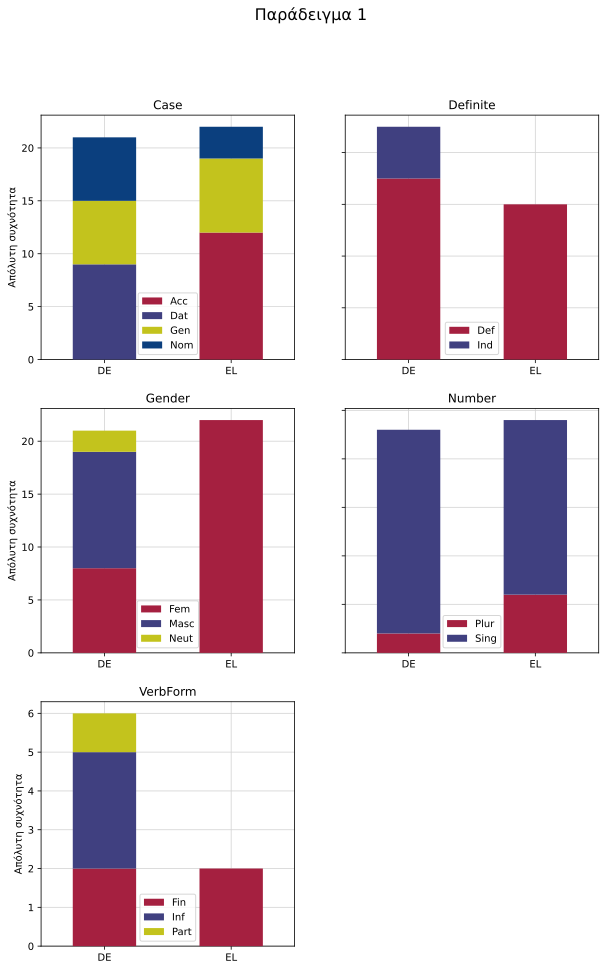

In [25]:
# create a new dataframe by copying the columns 'id', 'lang', 'version' and 'morphology'
df = texts[['id', 'lang', 'version', 'morphology']].copy()
df['morphology'] = df['morphology'].apply(json.loads)

# expand the dataframe by adding a new row for each token in the text
df = df.explode('morphology')

# expand the morphology column into columns
# df = pd.concat([df.drop(['morphology'], axis=1), df['morphology'].apply(pd.Series)], axis=1)

# convert the key of the dictionary to a column by splitting on ':'
df = (pd.concat([
        df.drop(['morphology'], axis=1),
        df['morphology']
            .apply(pd.Series, dtype='object')
            .stack()
            .reset_index(level=1, name='morphology')
        ],
        axis=1)
    )

# expand the morphology column into new columns
df = pd.concat([df.drop(['morphology'], axis=1),
                df['morphology'].apply(pd.Series, dtype='object')], axis=1)

df_grouped = df.groupby(['id', 'lang'])

cols = [col for col in df.columns
        if col[0].isupper()
        and len(df_grouped[col].value_counts().unstack().columns) > 1]

import math

num_plots = len(cols)
n_rows = math.ceil(num_plots / 2)
n_cols = 2 if num_plots > 1 else 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows))

for i, col in enumerate(cols):
    fig.suptitle(f"Παράδειγμα {df_grouped[col].value_counts().unstack().index[0][0]}", fontsize=16)
    ax = axes[i // n_cols, i % n_cols]
    ax.set_ylabel('Απόλυτη συχνότητα')
    ax.set_title(col)
    (df_grouped[col]
        .value_counts()
        .unstack()
        .plot(
            kind='bar',
            ax=ax,
            # set different colors for each value of the column
            color=[list(COLORS.values())[i]
                   for i, _ in enumerate(df_grouped[col]
                                            .value_counts()
                                            .unstack()
                                            .columns)
                   ],
            stacked=True,
            sharey=True,
            rot=0,
            zorder=3
        )
    )
    xticks = [str(i).removeprefix('(').removesuffix(')').replace("'", '')
              .upper().split(',')[1].strip()
              for i in df_grouped[col].value_counts().unstack().index]
    ax.set_xticklabels(xticks)
    ax.set_xlabel(None)
    ax.legend().set_title(None)
    ax.legend(loc='lower center')
    ax.grid(axis='both', color='lightgray', zorder=0)

# check if the number of plots is odd and remove the last subplot
if num_plots % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.show();


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

n_colors = 256  # Number of colors you want to generate
palette = sns.color_palette('gist_stern', n_colors=n_colors)
color_list = [mcolors.rgb2hex(color) for color in palette]
print('$colors: (\n\t', ", ".join(color_list), '\n);')


In [26]:
grouped = texts.groupby(['id', 'lang']).agg({'length': ['mean', 'std']}).reset_index()
grouped


id lang length          
            mean       std
0  1   de   18.5  3.535534
1  1   el   14.5  0.707107

In [27]:
# Take the grouped data by id and lang. Then calculate how different the pos tags are in each language and plot the results.
grouped_ = texts.groupby(['id', 'lang']).agg({'pos': lambda x: x.value_counts().index[0]}).reset_index()
grouped_['pos'] = grouped_['pos'].str.split(' ')
grouped_['pos_diff'] = grouped_['pos'].apply(lambda x: len(set(x)) / len(x))
grouped_ = grouped_.drop(columns=['pos'])
grouped_


,id,lang,pos_diff
0,1,de,0.409091
1,1,el,0.500000


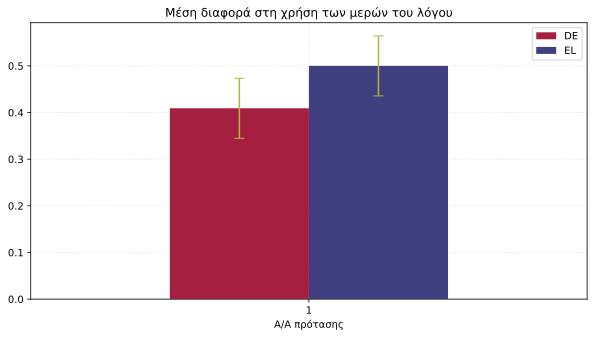

In [29]:
from matplotlib.lines import Line2D

(grouped_
    .groupby(['id', 'lang'])
    .agg({'pos_diff': 'mean'})
    .unstack()
    .plot(kind='bar', figsize=(10, 5), zorder=3, color=COLORS.values(),
          yerr=grouped_['pos_diff'].std(),
          error_kw={'capsize': 5, 'ecolor': COLORS['err']})
)
plt.legend(['DE', 'EL'])
plt.title('Μέση διαφορά στη χρήση των μερών του λόγου')
plt.xticks(rotation=0)
plt.xlabel('Α/Α πρότασης')
plt.grid(axis='both', alpha=0.25, linestyle='--', zorder=0)
plt.show();
